## MAP Elites for Knight's Touring
### Implementation using the pyribs library


First, we need to import the pyribs library and some other packages we will need.

In [1]:
try:
    import ribs
except Exception as e:
    print(e)
    %pip install ribs[visualize]

import time
import sys
import numpy as np
from tqdm import trange

Since we are going to be using the knight's tour benchmark with handpicked measures, we include the following lines

In [2]:
from qdglue.tasks.knights_tour import KnightsTour

knights_tour = KnightsTour("hand")

In [5]:
# parameters
total_itrs = 10_000
batch_size = 1024

Since we are using the vanilla MAP-Elites algorithm, we simply use the pyribs GridArchive with the following parameters:

In [6]:
from ribs.archives import GridArchive

archive = GridArchive(
    solution_dim=66,
    dims=[8, 8],
    threshold_min=-np.inf,
    ranges=[(0, 8)] * 2)

The following line includes an emitter. Note that the Knight's tour benchmark requires a discrete input vector containing integers in the range $[0, 7]$. Here, we use a continuous representation that we will floor to an integer during evaulation.

In [7]:
from ribs.emitters import GaussianEmitter

emitters = [
    GaussianEmitter(
        archive=archive,
        sigma=0.3,
        x0=np.array([4.0 for i in range(66)]),
        bounds=[(0.0, 7.99)] * 66,
        batch_size=batch_size//4,
    ) for _ in range(4)
]

In [8]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

In [9]:
metrics = {
    "Archive Size": {
        "itrs": [0],
        "vals": [0],  # Starts at 0.
    },
    "Max Objective": {
        "itrs": [],
        "vals": [],  # Does not start at 0.
    },
}

for itr in trange(1, total_itrs + 1, desc='Iterations', file=sys.stdout):
    sols = scheduler.ask()
    objs, _, feats, _ = knights_tour.evaluate(np.floor(sols).astype(int))
    scheduler.tell(objs, feats)

    # Logging.
    if itr % 50 == 0:
        metrics["Archive Size"]["itrs"].append(itr)
        metrics["Archive Size"]["vals"].append(len(archive))
        metrics["Max Objective"]["itrs"].append(itr)
        metrics["Max Objective"]["vals"].append(archive.stats.obj_max)

Iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:50<00:00, 43.38it/s]


Final Archive Size: 64
Final Max Objective: 38


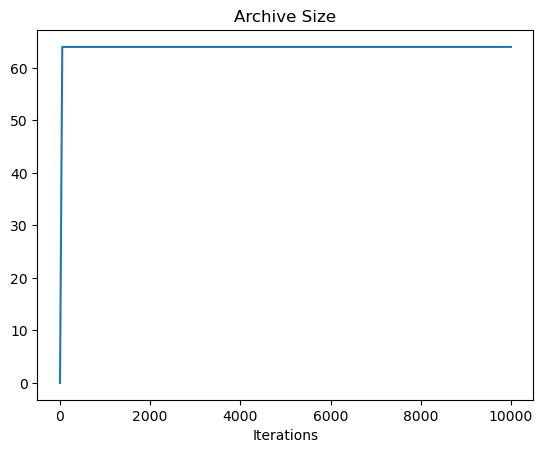

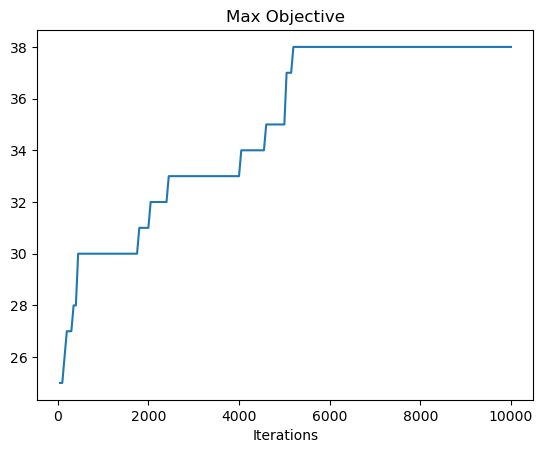

In [14]:
import matplotlib.pyplot as plt

for metric in metrics:
    plt.figure()
    plt.plot(metrics[metric]["itrs"], metrics[metric]["vals"])
    plt.title(metric)
    plt.xlabel("Iterations")
    print(f"Final {metric}: {metrics[metric]['vals'][-1]}")

Text(0.5, 1.0, 'Final Position of Knight')

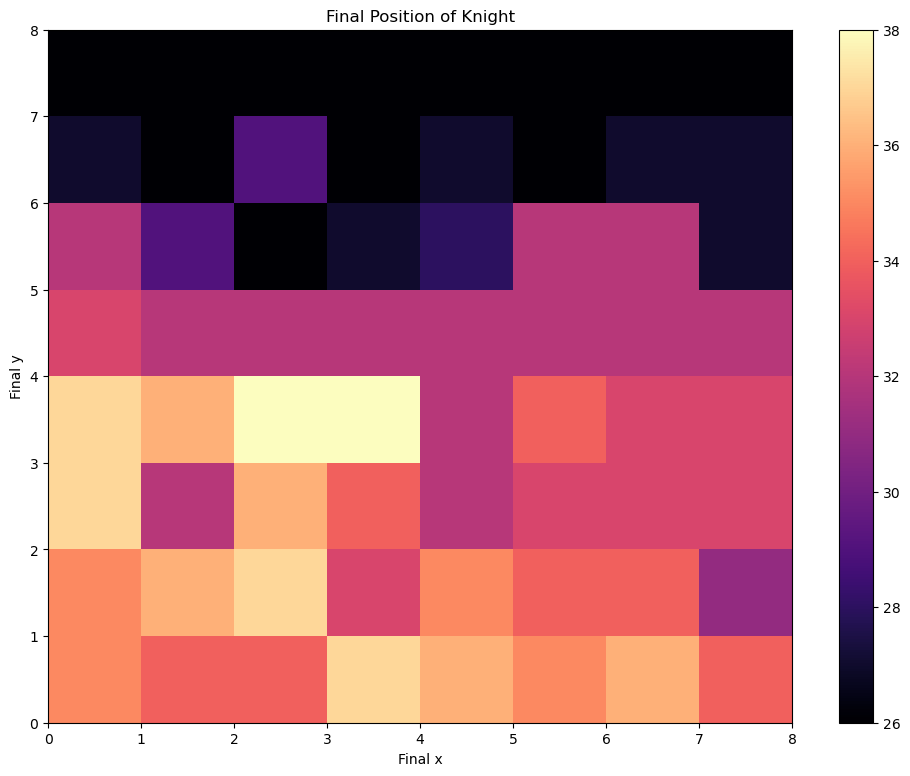

In [13]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(12, 9))
grid_archive_heatmap(archive)
plt.xlabel("Final x")
plt.ylabel("Final y")
plt.title("Final Position of Knight")